In [1]:
from model import *
from utils import * 
from optimizer import *
import random
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## Initialize dataset

In [2]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2


In [3]:
max_n_nodes = get_max_n_nodes(dataset)
print(f'Max number of nodes: {max_n_nodes}')

Max number of nodes: 28


In [4]:
dataset = update_dataset(dataset, max_n_nodes)

In [5]:
torch.manual_seed(12345)
random.shuffle(dataset)

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [6]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

## Initialize & train a model

In [7]:
n_nodes = 28
feat_dim = 7
hidden1 = 16
hidden2 = 8
dropout = 0.0
lr = 1e-4
epochs = 150
log_interval = 25
save_file = 'model'

In [8]:
model = GCNModelVAE(n_nodes, feat_dim, hidden1, hidden2)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [9]:
log = fit(model, optimizer, train_loader, test_loader, epochs, save_file)

Training for 150 epochs: 100%|████████████████| 150/150 [00:14<00:00, 10.22it/s]

Optimization Finished!
Best epoch: 120 , Best test set loss: 74.7897


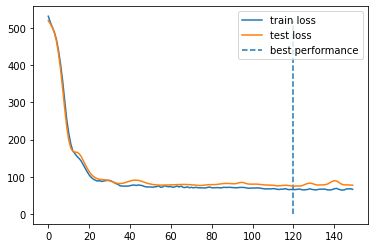

In [10]:
performance_plot(log)